# Atividade 9 - Classificador Random Forests

# PCA

# Algoritmo RandomForestClassifier

● Semelhante aos anteriores, usando Random Forests

● Parâmetros a serem calibrados: <br>
    – mtry / max_features (o parâmetro mais sensível): raiz (quadrada) de n, n sendo o número de características (testar outros) <br>
    – ntree = 500 (quanto maior melhor, depende do tempo disponível)

## Dataset Completo

In [17]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from pprint import pprint

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# PCA
from sklearn.decomposition import PCA

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.ensemble import RandomForestClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


## Pré-Processamento

In [3]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [4]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [5]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [6]:
df_imp = df_processed.copy()

In [7]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## PCA (matriz de correlação)

In [8]:
scaler = preprocessing.StandardScaler()
X_imp = df_imp.drop('Biopsy', axis=1)

X_std = pd.DataFrame(scaler.fit_transform(X_imp) , columns = X_imp.columns.tolist())

#X_std.describe()

In [9]:
pca_corr = PCA()
pca_corr.fit(X_std)

#pd.DataFrame(pca_corr.get_covariance(), columns = df_imp.columns.tolist()).head()

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
autovalores_corr = pca_corr.explained_variance_.tolist()
variancia_corr = pca_corr.explained_variance_ratio_
variancia_acumulada_corr = np.cumsum(variancia_corr.tolist())

print('\tAuto-valores\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada_corr):
    print(num+1,'\t' + '%0.3f' % autovalores_corr[num] + '\t\t' +'%0.3f' %variancia_corr[num],'\t\t\t'+ '%0.2f' %item)

	Auto-valores	Variância explicada	Variância acumulada

1 	5.116		0.155 			0.15
2 	3.028		0.092 			0.25
3 	2.473		0.075 			0.32
4 	2.078		0.063 			0.38
5 	2.017		0.061 			0.45
6 	1.716		0.052 			0.50
7 	1.546		0.047 			0.54
8 	1.361		0.041 			0.59
9 	1.278		0.039 			0.62
10 	1.235		0.037 			0.66
11 	1.064		0.032 			0.69
12 	1.029		0.031 			0.72
13 	1.008		0.031 			0.76
14 	0.935		0.028 			0.78
15 	0.857		0.026 			0.81
16 	0.843		0.026 			0.83
17 	0.811		0.025 			0.86
18 	0.795		0.024 			0.88
19 	0.745		0.023 			0.91
20 	0.654		0.020 			0.93
21 	0.572		0.017 			0.94
22 	0.478		0.014 			0.96
23 	0.320		0.010 			0.97
24 	0.276		0.008 			0.98
25 	0.234		0.007 			0.98
26 	0.175		0.005 			0.99
27 	0.125		0.004 			0.99
28 	0.092		0.003 			0.99
29 	0.076		0.002 			1.00
30 	0.066		0.002 			1.00
31 	0.030		0.001 			1.00
32 	0.008		0.000 			1.00
33 	0.000		0.000 			1.00
34 	0.000		0.000 			1.00
35 	0.000		0.000 			1.00


In [11]:
max_var = []
for num in range(0, len(variancia_corr)):
    if variancia_corr[num] > 0.02: # threshold - queremos variancia mais que 0.02
        max_var.append(num)

best_var = max(max_var)
# +1 porque a tabela acima começa com 1 e nao com 0 
print('{} - {:.3f}'.format(best_var+1,variancia_corr[best_var]))

19 - 0.023


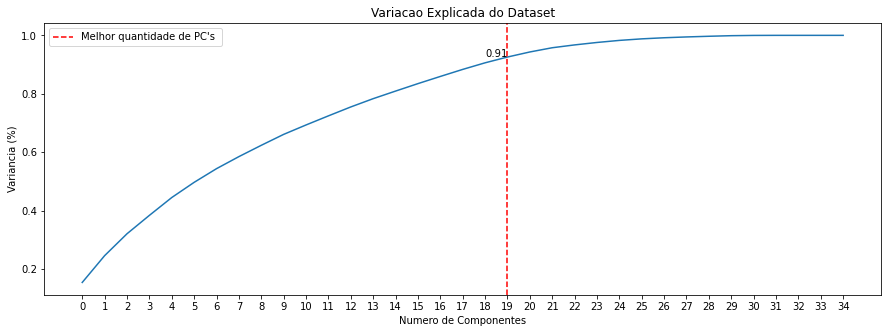

In [12]:
# Plotando o somatório cumulativo da variação explicada
PCA_MinMax = plt.figure(figsize=(15,5))
plt.plot(np.cumsum(variancia_corr))
plt.xlabel('Numero de Componentes')
plt.ylabel('Variancia (%)') #for each component
plt.xticks(range(0,35))
plt.axvline(best_var+1, 0, 1, label='Melhor quantidade de PC\'s ',  color='r', linestyle='--')
plt.legend()
plt.title('Variacao Explicada do Dataset')
plt.annotate('{:.2f}'.format(variancia_acumulada_corr[best_var]),
            xy=(best_var, variancia_acumulada_corr[best_var]+0.02), )
plt.show()

PCA_MinMax.savefig("PCA_MinMax.png", bbox_inches='tight', dpi=600)

In [13]:
numero_pcs = 12

pca_corr = PCA(n_components=numero_pcs)
df_pca = pd.DataFrame(pca_corr.fit_transform(X_std))
df_pca = df_pca.join(df_imp['Biopsy'])

df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,Biopsy
0,-0.812797,-1.027743,-0.345739,0.404892,1.065839,-0.095333,-1.243888,-0.121172,-0.511011,-0.162216,-0.637531,-0.025541,0
1,-0.899585,-1.273128,-0.714851,0.461655,1.137552,0.103197,-1.278217,0.103286,-0.570671,-0.077276,0.096251,-0.310135,0
2,-0.815944,-0.654912,-0.484969,0.345744,0.146147,-0.174483,-0.648625,0.852528,0.218536,0.964763,-0.269013,-0.088174,0
3,1.486477,11.658630,10.985148,-3.326634,6.833256,-4.245882,0.061749,2.355005,-0.503995,0.642337,1.203832,0.816032,0
4,-0.630958,0.984706,0.638403,-0.135889,-2.382506,-0.246263,3.192567,0.173985,1.118971,0.326163,-0.079618,-0.048941,0


## Stratified Cross- Validation

### Dataset Desbalanceado

In [14]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    max_features = grid_params.get('max_features')
    n_estimators = grid_params.get('n_estimators')
    #max_depth = grid_params.get('max_depth')
    #min_samples_split = grid_params.get('min_samples_split')
    #min_samples_leaf = grid_params.get('min_samples_leaf')
    #bootstrap = grid_params.get('bootstrap')
    
    
    # Testa varias max_features
    for mf in max_features:
        print("-> Teste max_features {}".format(mf))
        
        # Testa n_estimators
        for n_estim in n_estimators:
            print("-> Teste n_estimators {}".format(mf))
            
#             # Testa max_depth
#             for md in max_depth:
#                 print("-> Teste max_depth {}".format(md))
                
#                 # Testa min_samples_split
#                 for min_ss in min_samples_split:
#                     print("-> Teste min_samples_split {}".format(min_ss))
                    
#                     # Testa min_samples_leaf
#                     for min_sl in min_samples_leaf:
#                         print("-> Teste min_samples_leaf {}".format(min_sl))
                        
#                         # Testa bootstrap
#                         for bs in bootstrap:
#                             print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {} | min_samples_leaf {} | bootstrap {}'.format(mf, n_estim, md, min_ss, min_sl, bs))
#                             clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss, min_samples_leaf=min_sl, bootstrap=bs, verbose=0, random_state = random_state)
            print('\t-> Modelo: max_features ={} | n_estimators {}'.format(mf, n_estim))
            clf = algoritmo(max_features=mf, n_estimators=n_estim, verbose=0, random_state = random_state)

            # Folds
            for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                fold_number = fold
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                # quantidade de classes dentro da fold
                #REMOVED

                # aplica o classificador
                clf = clf.fit(X_train, y_train)

                # predict no dataset de treino 
                y_train_preds = clf.predict(X_train)
                # predict no dataset de teste
                y_pred = clf.predict(X_test)


                # Scores do model (utilizados dados nao-balanceados) - dados de teste
                recall = recall_score(y_test, y_pred)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                scores.append([mf, n_estim, fold_number, precision, recall, accuracy]) #md, min_ss, min_sl, bs, fold_number, precision, recall, accuracy])


    print("Treinamento Finalizado!")
    return np.array(scores)

### Dataset Balanceado

In [15]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    max_features = grid_params.get('max_features')
    n_estimators = grid_params.get('n_estimators')
    #max_depth = grid_params.get('max_depth')
    #min_samples_split = grid_params.get('min_samples_split')
    #min_samples_leaf = grid_params.get('min_samples_leaf')
    #bootstrap = grid_params.get('bootstrap')
    
    
    # Testa varias max_features
    for mf in max_features:
        print("-> Teste max_features {}".format(mf))
        
        # Testa n_estimators
        for n_estim in n_estimators:
            print("-> Teste n_estimators {}".format(mf))
          
            # Testa max_depth
#             for md in max_depth:
#                 print("-> Teste max_depth {}".format(md))

#                 # Testa min_samples_split
#                 for min_ss in min_samples_split:
#                     print("-> Teste min_samples_split {}".format(min_ss))

#                     # Testa min_samples_leaf
#                     for min_sl in min_samples_leaf:
#                         print("-> Teste min_samples_leaf {}".format(min_sl))

#                         # Testa bootstrap
#                         for bs in bootstrap:
#                             print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {} | min_samples_leaf {} | bootstrap {}'.format(mf, n_estim, md, min_ss, min_sl, bs))
#                             clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss, min_samples_leaf=min_sl, bootstrap=bs,verbose=0, random_state = random_state)
            print('\t-> Modelo: max_features ={} | n_estimators {}'.format(mf, n_estim))
            clf = algoritmo(max_features=mf, n_estimators=n_estim, verbose=0, random_state = random_state)

            # Folds
            for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                fold_number = fold
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                # Normaliza MinMax para aplicar Smote
                X_train_normalized = minmax_scale.fit_transform(X_train)
                X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                # SMOTETomek (apenas os dados de treino)
#                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                # Retorna para valores não normalizados
                X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
#                    print folds balanceados
                #REMOVED

                # quantidade de classes dentro da fold
                #REMOVED

                # aplica o classificador
                clf = clf.fit(X_train, y_train)

                # predict no dataset de treino 
                y_train_preds = clf.predict(X_train)
                # predict no dataset de teste
                y_pred = clf.predict(X_test)


                # Scores do model (utilizados dados nao-balanceados) - dados de teste
                recall = recall_score(y_test, y_pred)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                scores.append([mf, n_estim, fold_number, precision, recall, accuracy]) #md, min_ss, min_sl, bs, fold_number, precision, recall, accuracy])

    print("Treinamento Finalizado!")
    return np.array(scores)

## Grid de Parametros para teste

In [18]:
grid_params_all = {'max_features': ["sqrt", "log2", None], # Number of features to consider at every split
                   'n_estimators' : [100] + [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], # Number of trees in random forest # defautl = 100 
                   #'max_depth':  [int(x) for x in np.linspace(10, 110, num = 11)] + [None], # Maximum number of levels in tree
                   #'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
                   #'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
                   #'bootstrap': [True, False] # Method of selecting samples for training each tree
              }

pprint(grid_params_all)

{'max_features': ['sqrt', 'log2', None],
 'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


## Calculando Precisão, Revocação e Acurácia

### Algortimo-> RandomForestClassifier

### Dataset Desbalanceado

In [19]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_pca, k, RandomForestClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'max_features', 1: 'n_estimators', 2:'Fold', 3: 'Precision', 4: 'Recall', 5: 'Accuracy'}) 

scores_unbalanced['Algorimto'] = 'RandomForestClassifier'

#float_cols = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Fold', 'Precision', 'Recall', 'Accuracy']
float_cols = ['n_estimators', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')

#string_cols = ['max_features', 'bootstrap']
string_cols = ['max_features']
scores_unbalanced[string_cols] = scores_unbalanced[string_cols].astype(str)
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste max_features sqrt
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 100
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 800
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1000
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1800
-> Teste n_estimators sqr

In [20]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-PCA_RandomForestClassifier.xlsx', encoding='utf-8-sig')

,max_features,n_estimators,Fold,Precision,Recall,Accuracy,Algorimto
0,sqrt,100,1,0.571429,0.800000,0.953488,RandomForestClassifier
1,sqrt,100,2,0.666667,0.400000,0.953488,RandomForestClassifier
2,sqrt,100,3,0.666667,0.800000,0.965116,RandomForestClassifier
3,sqrt,100,4,1.000000,0.500000,0.965116,RandomForestClassifier
4,sqrt,100,5,0.285714,0.333333,0.895349,RandomForestClassifier


### Dataset Balanceado

In [22]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_pca, k, RandomForestClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'max_features', 1: 'n_estimators', 2:'Fold', 3: 'Precision', 4: 'Recall', 5: 'Accuracy'}) 

scores_balanced['Algorimto'] = 'RandomForestClassifier'

#float_cols = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Fold', 'Precision', 'Recall', 'Accuracy']
float_cols = ['n_estimators', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')

#string_cols = ['max_features', 'bootstrap']
string_cols = ['max_features']
scores_balanced[string_cols] = scores_balanced[string_cols].astype(str)
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste max_features sqrt
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 100
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 800
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1000
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1200
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1400
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1600
-> Teste n_estimators sqrt
	-> Modelo: max_features =sqrt | n_estimators 1800
-> Teste 

In [23]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-PCA_RandomForestClassifier.xlsx', encoding='utf-8-sig')

,max_features,n_estimators,Fold,Precision,Recall,Accuracy,Algorimto
0,sqrt,100,1,0.571429,0.800000,0.953488,RandomForestClassifier
1,sqrt,100,2,0.333333,0.400000,0.918605,RandomForestClassifier
2,sqrt,100,3,0.363636,0.800000,0.906977,RandomForestClassifier
3,sqrt,100,4,0.750000,0.500000,0.953488,RandomForestClassifier
4,sqrt,100,5,0.400000,0.666667,0.906977,RandomForestClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [24]:
mean_unbalanced = scores_unbalanced.groupby(['max_features', 'n_estimators']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
max_features n_estimators                               
None         100            0.663889  0.586667  0.949877
             200            0.670833  0.570000  0.951053
             400            0.628571  0.510000  0.945212
             600            0.638571  0.530000  0.946389
             800            0.663571  0.546667  0.948728
             1000           0.668929  0.566667  0.949891
             1200           0.638571  0.546667  0.946375
             1400           0.653571  0.546667  0.947551
             1600           0.653571  0.530000  0.947565
             1800           0.638571  0.530000  0.946389
             2000           0.663571  0.546667  0.948728
log2         100            0.735714  0.546667  0.954555
             200            0.719048  0.550000  0.954569
             400            0.719048  0.530000  0.953393
             600            0.719048  0.530000  0.953393
             800            0.735714  0.566667  0.955732
             1000           0.720238  0.550000  0.954569
             1200           0.720238  0.550000  0.954569
             1400           0.711905  0.530000  0.953406
             1600           0.711905  0.530000  0.953406
             1800           0.720238  0.550000  0.954569
             2000           0.736905  0.566667  0.955732
sqrt         100            0.735714  0.546667  0.954555
             200            0.719048  0.550000  0.954569
             400            0.719048  0.530000  0.953393
             600            0.719048  0.530000  0.953393
             800            0.735714  0.566667  0.955732
             1000           0.720238  0.550000  0.954569
             1200           0.720238  0.550000  0.954569
             1400           0.711905  0.530000  0.953406
             1600           0.711905  0.530000  0.953406
             1800           0.720238  0.550000  0.954569
             2000           0.736905  0.566667  0.955732

In [25]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
max_features n_estimators                               
sqrt         2000           0.736905  0.566667  0.955732
             800            0.735714  0.566667  0.955732
log2         2000           0.736905  0.566667  0.955732
             800            0.735714  0.566667  0.955732
             200            0.719048  0.550000  0.954569

('log2', 800)

### Dataset Balanceado

In [26]:
mean_balanced = scores_balanced.groupby(['max_features', 'n_estimators']).mean().drop('Fold', axis = 1)
mean_balanced

Precision  Recall  Accuracy
max_features n_estimators                             
None         100            0.466419    0.65  0.926566
             200            0.467674    0.65  0.925390
             400            0.463095    0.65  0.925390
             600            0.463095    0.65  0.925390
             800            0.465476    0.65  0.926566
             1000           0.456429    0.65  0.924227
             1200           0.456429    0.65  0.924227
             1400           0.463095    0.65  0.925390
             1600           0.463095    0.65  0.925390
             1800           0.463095    0.65  0.925390
             2000           0.463095    0.65  0.925390
log2         100            0.527078    0.67  0.935910
             200            0.563745    0.67  0.938249
             400            0.534221    0.67  0.935910
             600            0.560173    0.67  0.937073
             800            0.560173    0.67  0.937073
             1000           0.563810    0.67  0.938235
             1200           0.554286    0.67  0.937073
             1400           0.557316    0.67  0.938235
             1600           0.554286    0.67  0.937073
             1800           0.557316    0.67  0.938235
             2000           0.557316    0.67  0.938235
sqrt         100            0.527078    0.67  0.935910
             200            0.563745    0.67  0.938249
             400            0.534221    0.67  0.935910
             600            0.560173    0.67  0.937073
             800            0.560173    0.67  0.937073
             1000           0.563810    0.67  0.938235
             1200           0.554286    0.67  0.937073
             1400           0.557316    0.67  0.938235
             1600           0.554286    0.67  0.937073
             1800           0.557316    0.67  0.938235
             2000           0.557316    0.67  0.938235

In [27]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision  Recall  Accuracy
max_features n_estimators                             
log2         200            0.563745    0.67  0.938249
sqrt         200            0.563745    0.67  0.938249
log2         1000           0.563810    0.67  0.938235
sqrt         1800           0.557316    0.67  0.938235
             1400           0.557316    0.67  0.938235

('log2', 200)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [28]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['max_features'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['n_estimators'] == max_alpha_unbalanced[1])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.956, IC = [0.938, 0.973]
Recall: Média = 0.567, IC = [0.424, 0.710]
Precisão: Média = 0.736, IC = [0.573, 0.899]


### Dataset Balanceado

In [29]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['max_features'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['n_estimators'] == max_alpha_balanced[1])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.938, IC = [0.916, 0.961]
Recall: Média = 0.670, IC = [0.532, 0.808]
Precisão: Média = 0.564, IC = [0.405, 0.723]


## Gráfico

In [30]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

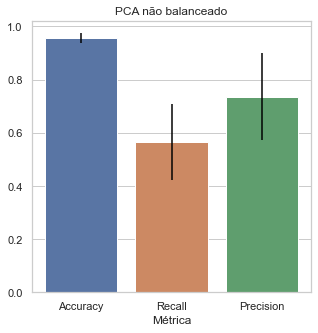

In [31]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('PCA não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('PCA nao balanceado - RandomForestClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

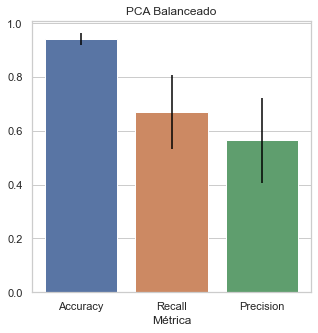

In [32]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('PCA Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('PCA balanceado - RandomForestClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [33]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    'RandomForestClassifier',
    '9',
    'PCA Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    'RandomForestClassifier',
    '9',
    'PCA Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Accuracy,0.896129,"[0.896, 0.857, 0.935]"
1,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Recall,0.02,"[0.020, -0.025, 0.065]"
2,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Precision,0.00666667,"[0.007, -0.008, 0.022]"
3,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Accuracy,0.690109,"[0.690, 0.473, 0.907]"
4,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Recall,0.216667,"[0.217, -0.049, 0.482]"
5,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Precision,0.0492712,"[0.049, -0.024, 0.123]"
6,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Accuracy,0.822886,"[0.823, 0.784, 0.862]"
7,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Recall,0.153333,"[0.153, 0.034, 0.272]"
8,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Precision,0.0906421,"[0.091, 0.013, 0.169]"
9,Naive Bayes,6,Branch and Bound Balanceado - Normalizado,0.1,Accuracy,0.512845,"[0.513, 0.416, 0.610]"


Resultados salvos com sucesso
